### 유해시설 점수 가중치 선정을 위한 타깃 생성

In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor



# 1. 데이터 불러오기
df_pm = pd.read_csv('WhoMergedPm.csv', encoding='utf-8-sig')

# 2. 월별 컬럼 추출 및 평균 계산
month_cols = [col for col in df_pm if '.' in col]
df_pm['평균농도'] = df_pm[month_cols].mean(axis=1)
# 3. 상위 50% 지역 추출
cut_value = df_pm['평균농도'].quantile(0.5)
top50_df = df_pm[df_pm['평균농도'] >= cut_value].copy()

# 결과 확인
print(top50_df[['지역', '평균농도']])

          지역        평균농도
7     강원도 영월  106.152778
8     강원도 원주  133.958333
12    강원도 춘천  114.500000
17    강원도 횡성  104.736111
19    경기도 고양  122.097222
..       ...         ...
157  충청북도 제천  115.138889
158  충청북도 증평  130.680556
159  충청북도 진천  121.152778
160  충청북도 청주  129.888889
161  충청북도 충주  117.750000

[81 rows x 2 columns]


### 유해시설 점수 계산식을 위한 가중치 산출

In [18]:
# 유해시설 데이터 불러오기
df_hazard = pd.read_csv('hazard_facility.csv')  

df_ml = df_hazard.merge(top50_df[['지역', '평균농도']], on='지역')

hazard_cols = [
    '사업장 수(1종)', '사업장 수(2종)', '사업장 수(3종)',
    '배출구 수(1종)', '배출구 수(2종)', '배출구 수(3종)',
    '방지시설 수(1종)', '방지시설 수(2종)', '방지시설 수(3종)',
    '배출시설 수(1종)', '배출시설 수(2종)', '배출시설 수(3종)'
]

X = df_ml[hazard_cols]
y = df_ml['평균농도']

# 랜덤포레스트 회귀로 변수 중요도 산출
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# 가중치(중요도) 정규화
weights = importances / importances.sum()
weight_dict = dict(zip(hazard_cols, weights))

print("각 항목별 가중치:")
for k, v in weight_dict.items():
    print(f"{k}: {v:.3f}")


각 항목별 가중치:
사업장 수(1종): 0.052
사업장 수(2종): 0.069
사업장 수(3종): 0.068
배출구 수(1종): 0.115
배출구 수(2종): 0.049
배출구 수(3종): 0.080
방지시설 수(1종): 0.083
방지시설 수(2종): 0.074
방지시설 수(3종): 0.065
배출시설 수(1종): 0.079
배출시설 수(2종): 0.118
배출시설 수(3종): 0.149


### 유해시설점수

In [20]:
# 유해시설 관련 컬럼의 NaN을 0으로 바꾸기
df_hazard[hazard_cols] = df_hazard[hazard_cols].fillna(0)

# 점수 계산
df_hazard['유해시설점수'] = 0
for col in hazard_cols:
    df_hazard['유해시설점수'] += df_hazard[col] * weight_dict.get(col, 0)

print(df_hazard[['지역', '유해시설점수']])

          지역       유해시설점수
0     강원도 강릉    70.178085
1     강원도 고성    11.074389
2     강원도 동해    73.064177
3     강원도 삼척    90.010478
4     강원도 속초     0.495782
..       ...          ...
155    부산광역시  1230.495211
156    서울특별시   144.508546
157  세종특별자치시   413.625028
158    울산광역시  3754.032071
159    인천광역시  1219.344482

[160 rows x 2 columns]


### 클러스터링을 위한 데이터프레임 병합

In [29]:


tmp_result = pd.read_csv("tmp_score_result.csv", encoding='utf-8-sig')

# df_hosp_pop와 df_hosp_area를 tmp_score_result에서 생성
df_hosp_pop = tmp_result[['지역', '인구10k명당_의료기관수']].copy()
df_hosp_pop.columns = ['지역', '인구10k명당_의료기관수']

df_hosp_area = tmp_result[['지역', '면적1km2당_의료기관수']].copy()
df_hosp_area.columns = ['지역', '면적1km2당_의료기관수']

# 1. 마지막 글자 '시' 또는 '군' 제거 함수
area_names = [
    "서울특별시",
    "부산광역시",
    "대구광역시",
    "인천광역시",
    "광주광역시",
    "대전광역시",
    "울산광역시",
    "세종특별자치시"
]
def remove_suffix(name):
    if name in area_names:
        return name
    if name.endswith('시') or name.endswith('군') or name.endswith('구'):
        return name[:-1]
    return name
df_hosp_pop['지역'] = df_hosp_pop['지역'].apply(remove_suffix)
df_hosp_area['지역'] = df_hosp_area['지역'].apply(remove_suffix)
df_pm['지역'] = df_pm['지역'].apply(remove_suffix)


# 2. 데이터 병합
print("병합 전 df_hosp_area 지역 수:", len(df_hosp_area))
print("병합 전 df_pm 지역 수:", len(df_pm))
print("병합 전 df_hosp_pop 지역 수:", len(df_hosp_pop))
print("병합 전 df_hazard 지역 수:", len(df_hazard))

# 1차 병합
df = df_hosp_area.merge(df_pm[['지역', '평균농도']], on='지역', how='left')
# print("1차 병합 후 shape:", df.shape)
# print("1차 병합에서 누락된 지역:", df[df['평균농도'].isnull()]['지역'].tolist())

# 2차 병합
df = df.merge(df_hosp_pop, on='지역', how='left')
# print("2차 병합 후 shape:", df.shape)
# print("2차 병합에서 누락된 지역:", df[df['hosp_pop_score'].isnull()]['지역'].tolist())

# 3차 병합
df = df.merge(df_hazard[['지역', '유해시설점수']], on='지역', how='left')
# print("3차 병합 후 shape:", df.shape)
# print("3차 병합에서 누락된 지역:", df[df['유해시설점수'].isnull()]['지역'].tolist())



병합 전 df_hosp_area 지역 수: 161
병합 전 df_pm 지역 수: 162
병합 전 df_hosp_pop 지역 수: 161
병합 전 df_hazard 지역 수: 160


### 클러스터링 변수 정규화 & 클러스터링

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# 클러스터링 변수에 유해시설점수 추가(0~100에 맞춤춤)
def minmax_100(series):
    return 100 * (series - series.min()) / (series.max() - series.min())
# 각 feature별 점수화 및 컬럼명 지정
df['pm_score'] = minmax_100(df['평균농도'])
df['hazard_score'] = minmax_100(df['유해시설점수'])
df['area_score'] = minmax_100(df['면적1km2당_의료기관수'])
df['pop_score'] = minmax_100(df['인구10k명당_의료기관수'])

# hazard.csv에 청송, 영양, 남해, 양구 존재하지 않아 병합x
df = df.dropna()
#print(df.isnull().sum())

features = ['pm_score', 'hazard_score', 'area_score', 'pop_score']

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. KMeans 클러스터링
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 7. 군집별 지역명 리스트 출력
for i in range(n_clusters):
    지역리스트 = df[df['cluster'] == i]['지역'].tolist()
    print(f'군집 {chr(65+i)}: {", ".join(지역리스트)}')

군집 A: 부산광역시, 인천광역시, 울산광역시, 경기도 평택, 전라남도 여수, 경상북도 구미, 경기도 안산, 충청북도 청주, 경상북도 포항, 경상남도 창원
군집 B: 대구광역시, 광주광역시, 대전광역시, 세종특별자치시, 경기도 의정부, 경기도 광명, 경기도 동두천, 경기도 과천, 경기도 구리, 경기도 남양주, 경기도 오산, 경기도 시흥, 경기도 군포, 경기도 의왕, 경기도 하남, 경기도 파주, 경기도 이천, 경기도 안성, 경기도 김포, 경기도 화성, 경기도 광주, 경기도 양주, 경기도 포천, 경기도 여주, 경기도 연천, 경기도 양평, 충청북도 충주, 충청북도 제천, 충청북도 증평, 충청북도 진천, 충청북도 음성, 충청남도 아산, 충청남도 서산, 충청남도 당진, 충청남도 당진, 충청남도 홍성, 전라남도 목포, 전라남도 광양, 전라남도 영암, 경상북도 김천, 경상북도 영주, 경상북도 경산, 경상북도 칠곡, 경상남도 진주, 경상남도 김해, 경상남도 거제, 경상남도 양산, 강원도 춘천, 강원도 원주, 강원도 강릉, 강원도 횡성, 강원도 영월, 전라북도 군산, 전라북도 익산, 전라북도 김제, 전라북도 완주, 전라북도 부안, 경기도 수원, 경기도 성남, 경기도 고양, 경기도 용인, 경기도 안양, 충청남도 천안, 전라북도 전주
군집 C: 서울특별시, 경기도 부천
군집 D: 경기도 가평, 충청북도 보은, 충청북도 옥천, 충청북도 영동, 충청북도 괴산, 충청북도 단양, 충청남도 공주, 충청남도 보령, 충청남도 논산, 충청남도 계룡, 충청남도 금산, 충청남도 부여, 충청남도 서천, 충청남도 청양, 충청남도 예산, 충청남도 태안, 전라남도 순천, 전라남도 나주, 전라남도 담양, 전라남도 곡성, 전라남도 구례, 전라남도 고흥, 전라남도 보성, 전라남도 화순, 전라남도 장흥, 전라남도 강진, 전라남도 해남, 전라남도 무안, 전라남도 함평, 전라남도 영광, 전라남도 장성, 전라남도 완도, 전라남도 진도, 전라남도 신안, 경상북도 경주, 경상북도 안동, 경상북도 영천, 경상북도 상주, 

c:\Users\080a3\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [34]:
# 군집별 주요 변수의 평균, 표준편차, 최소, 최대, 개수 등 요약 통계 구하기
print(df.groupby('cluster')[features].mean())


          pm_score  hazard_score  area_score  pop_score
cluster                                                
0        53.023854      3.717676    2.182417  47.008096
1        80.012191      4.785055   14.931662  29.419633
2        63.969453     46.427390    6.641699  24.990949
3        19.464307      0.608880    0.368047  64.728039



## =>  군집1 : 미세먼지 중심 의료취약 지역

### 클러스터링 결과 시각화

In [35]:
import folium 
import geopandas as gpd
import pandas as pd
import os

sido_info = [
    ('서울', '11'), ('부산', '26'), ('대구', '27'), ('인천', '28'), ('광주', '29'),
    ('대전', '30'), ('울산', '31'), ('세종', '36'), ('경기', '41'), ('강원', '51'),
    ('충북', '43'), ('충남', '44'), ('전북', '52'), ('전남', '46'), ('경북', '47'),
    ('경남', '48'), ('제주', '50')
]
# 지역명 정제 함수
def clean_region_name(name):
    name = str(name).strip()
    for suf in ['시', '군', '구']:
        if name.endswith(suf):
            return name[:-1]
    return name
merged_gdf_list = []

for sido_name, sido_code in sido_info:
    shp_path = f'./LatLng/LARD_ADM_SECT_SGG_{sido_name}/LARD_ADM_SECT_SGG_{sido_code}_202505.shp'
    if not os.path.exists(shp_path):
        print(f"{sido_name} SHP 파일 없음: {shp_path}")
        continue
    try:
        gdf = gpd.read_file(shp_path, encoding='cp949')
    except Exception as e:
        print(f"{sido_name} 파일을 읽을 수 없습니다: {e}")
        continue

    if 'SGG_NM' not in gdf.columns:
        print(f"{sido_name}의 SHP 파일에 'SGG_NM' 컬럼이 없습니다.")
        continue

    # 시군구명에서 마지막 단어만 추출(예: '전라남도 목포시' → '목포시')
    gdf['SGG_NM'] = gdf['SGG_NM'].str.strip().str.split().str[-1]

    # 좌표계 통일
    try:
        gdf = gdf.to_crs(epsg=4326)
    except Exception as e:
        print(f"{sido_name} CRS 변환 실패: {e}")
        continue

    merged_gdf_list.append(gdf)

# 3. SHP 병합
if not merged_gdf_list:
    raise ValueError("병합할 SHP 데이터가 없습니다.")
merged_gdf = gpd.GeoDataFrame(pd.concat(merged_gdf_list, ignore_index=True), crs="EPSG:4326")
merged_gdf['도시_매칭'] = merged_gdf['SGG_NM'].apply(clean_region_name)


#1. df에 시군구명만 추출
df['도시_매칭'] = df['지역'].apply(lambda x: x.strip().split()[-1])

# 2. 병합
plot_gdf = merged_gdf.merge(df[['도시_매칭', 'cluster']], on='도시_매칭', how='left')

# 3. 군집별 색상 지정
cluster_colors = {
    0: "#66c2a5",  # 군집A: green
    1: "#fc8d62",  # 군집B: orange
    2: "#8da0cb",  # 군집C: blue
    3: "#a55194"   # 군집D: purple
}

def style_function(feature):
    cluster = feature['properties']['cluster']
    color = cluster_colors.get(cluster, "#cccccc")  # 군집 없으면 회색
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.8,
    }

# 4. Folium 지도 생성
m = folium.Map(location=[36.5, 127.8], zoom_start=7, tiles='cartodbpositron')

# 5. GeoJson으로 군집별 색상 시각화
folium.GeoJson(
    plot_gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['SGG_NM', 'cluster'], aliases=['지역', '군집'])
).add_to(m)

# 6. 군집별 범례 추가
from branca.element import MacroElement
from jinja2 import Template

legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 150px; height: 110px; 
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color: white;
    ">
    <b>&nbsp;군집 색상</b><br>
    &nbsp;<i style="background: #66c2a5; width: 10px; height: 10px; float: left; margin-right: 5px"></i>군집 A<br>
    &nbsp;<i style="background: #fc8d62; width: 10px; height: 10px; float: left; margin-right: 5px"></i>군집 B<br>
    &nbsp;<i style="background: #8da0cb; width: 10px; height: 10px; float: left; margin-right: 5px"></i>군집 C<br>
    &nbsp;<i style="background: #a55194; width: 10px; height: 10px; float: left; margin-right: 5px"></i>군집 D<br> 
</div>
{% endmacro %}
"""
legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# 7. 지도 저장 및 출력
m.save('cluster_map.html')
print("✅ 군집별 시군구 지도 저장 완료: cluster_map.html")

ModuleNotFoundError: No module named 'folium'

### 기존 임의 설정 의료취약점수 시각화

In [ ]:
import folium 
import geopandas as gpd
import pandas as pd
import os
from branca.colormap import LinearColormap


tmp_score = pd.read_csv('tmp_score_result.csv')
tmp_score['도시_매칭'] = tmp_score['지역'].apply(remove_suffix)
tmp_score['도시_매칭'] = tmp_score['지역'].apply(lambda x: x.strip().split()[-1])
tmp_score['도시_매칭'] = tmp_score['도시_매칭'].apply(clean_region_name)
# SHP 데이터와 의료취약점수 병합
plot_gdf = merged_gdf.merge(tmp_score[['도시_매칭', '의료접근_최종점수']], on='도시_매칭', how='left')

# 색상 범위 설정 (데이터 분포에 맞게 조정 필요)
min_score = plot_gdf['의료접근_최종점수'].min()
max_score = plot_gdf['의료접근_최종점수'].max()
colormap = LinearColormap(
    colors=['#800026', '#bd0026', '#e31a1c', '#fc4e2a', '#fd8d3c', '#feb24c', '#fed976', '#ffeda0', '#ffffcc'],
    vmin=min_score,
    vmax=max_score
)

# 스타일 함수 정의
def style_function(feature):
    score = feature['properties']['의료접근_최종점수']
    return {
        'fillColor': colormap(score) if pd.notnull(score) else '#cccccc',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

# Folium 지도 생성
m = folium.Map(location=[36.5, 127.8], zoom_start=7, tiles='cartodbpositron')

# GeoJson 레이어 추가
folium.GeoJson(
    plot_gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['SGG_NM', '의료접근_최종점수'],
        aliases=['지역', '의료접근_최종점수'],
        localize=True
    )
).add_to(m)



# 컬러맵 범례 추가
colormap.add_to(m)
colormap.caption = '의료 취약점수'

# 지도 저장
m.save('medical_vulnerability_map.html')
print("✅ 의료 취약점수 시각화 지도 저장 완료: medical_vulnerability_map.html")


✅ 의료 취약점수 시각화 지도 저장 완료: medical_vulnerability_map.html


### 군집B에 속하는 지역의 기존 의료취약점수 확인

In [ ]:
cluster_b = [
    "대구광역시", "광주광역시", "대전광역시", "세종특별자치시",
    "경기도 의정부", "경기도 광명", "경기도 동두천", "경기도 과천", "경기도 구리",
    "경기도 남양주", "경기도 오산", "경기도 시흥", "경기도 군포", "경기도 의왕",
    "경기도 하남", "경기도 파주", "경기도 이천", "경기도 안성", "경기도 김포",
    "경기도 화성", "경기도 광주", "경기도 양주", "경기도 포천", "경기도 여주",
    "경기도 연천", "경기도 양평", "충청북도 충주", "충청북도 제천", "충청북도 증평",
    "충청북도 진천", "충청북도 음성", "충청남도 아산", "충청남도 서산", "충청남도 당진",
    "충청남도 당진", "충청남도 홍성", "전라남도 목포", "전라남도 광양", "전라남도 영암",
    "경상북도 김천", "경상북도 영주", "경상북도 경산", "경상북도 칠곡",
    "경상남도 진주", "경상남도 김해", "경상남도 거제", "경상남도 양산",
    "강원도 춘천", "강원도 원주", "강원도 강릉", "강원도 횡성", "강원도 영월",
    "전라북도 군산", "전라북도 익산", "전라북도 김제", "전라북도 완주", "전라북도 부안",
    "경기도 수원", "경기도 성남", "경기도 고양", "경기도 용인", "경기도 안양",
    "충청남도 천안", "전라북도 전주"
]
# 0.515점 미달이면 의료취약지역
old_score = pd.read_csv('tmp_score_result.csv')
old_score['지역'] = old_score['지역'].apply(remove_suffix)
# 새롭게 포함된 의료취약지역
new_region = old_score[
    (old_score['지역'].isin(cluster_b)) &
    (old_score['의료접근_최종점수']>=0.465) & # 0.465~0.515는 기존 의료취약 지역 선정 오차 범위 내에 있다고 가정
    (old_score['의료접근_최종점수']<=0.565) # 0.515~0.565는 기존 의료취약 지역 선정 기준에 미치지 못한다고 가정
]
print(new_region[['지역', '의료접근_최종점수']])

          지역  의료접근_최종점수
12   경기도 동두천      0.476
23    경기도 안성      0.544
28    경기도 포천      0.502
33   충청북도 충주      0.517
34   충청북도 제천      0.481
38   충청북도 증평      0.558
41   충청북도 음성      0.495
46   충청남도 서산      0.526
49   충청남도 당진      0.530
119   강원도 춘천      0.556
121   강원도 강릉      0.478
137  전라북도 군산      0.543
138  전라북도 익산      0.527


In [ ]:
import folium 
import geopandas as gpd
import pandas as pd
import os
from branca.colormap import LinearColormap

new_region['도시_매칭'] = new_region['지역'].apply(lambda x: x.strip().split()[-1])
new_region['도시_매칭'] = new_region['도시_매칭'].apply(clean_region_name)
plot_gdf['new'] = plot_gdf['도시_매칭'].isin(new_region['도시_매칭']).astype(int)
print(plot_gdf.columns)

filtered_plot_gdf = plot_gdf[plot_gdf['new'] == 1]
# 스타일 함수 정의
def style_function(feature):
    score = feature['properties']['의료접근_최종점수']
    return {
        'fillColor': "#b5e30d",
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

# Folium 지도 생성
m = folium.Map(location=[36.5, 127.8], zoom_start=7, tiles='cartodbpositron')

# GeoJson 레이어 추가
folium.GeoJson(
    filtered_plot_gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['SGG_NM', '의료접근_최종점수'],
        aliases=['지역', '의료접근_최종점수'],
        localize=True
    )
).add_to(m)


# 지도 저장
m.save('new_region.html')
print("✅ 의료 취약점수 시각화 지도 저장 완료: new_region.html")


C:\Users\kjhh2\AppData\Local\Temp\ipykernel_22804\4022251512.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_region['도시_매칭'] = new_region['지역'].apply(lambda x: x.strip().split()[-1])
C:\Users\kjhh2\AppData\Local\Temp\ipykernel_22804\4022251512.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_region['도시_매칭'] = new_region['도시_매칭'].apply(clean_region_name)


Index(['ADM_SECT_C', 'SGG_NM', 'SGG_OID', 'COL_ADM_SE', 'geometry', '도시_매칭',
       '의료접근_최종점수', 'new'],
      dtype='object')
✅ 의료 취약점수 시각화 지도 저장 완료: new_region.html



✅ XGBoost Test Set 분류 리포트:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        32
           1       0.70      0.88      0.78        16

    accuracy                           0.83        48
   macro avg       0.81      0.84      0.82        48
weighted avg       0.85      0.83      0.84        48

Test Set ROC AUC: 0.9043


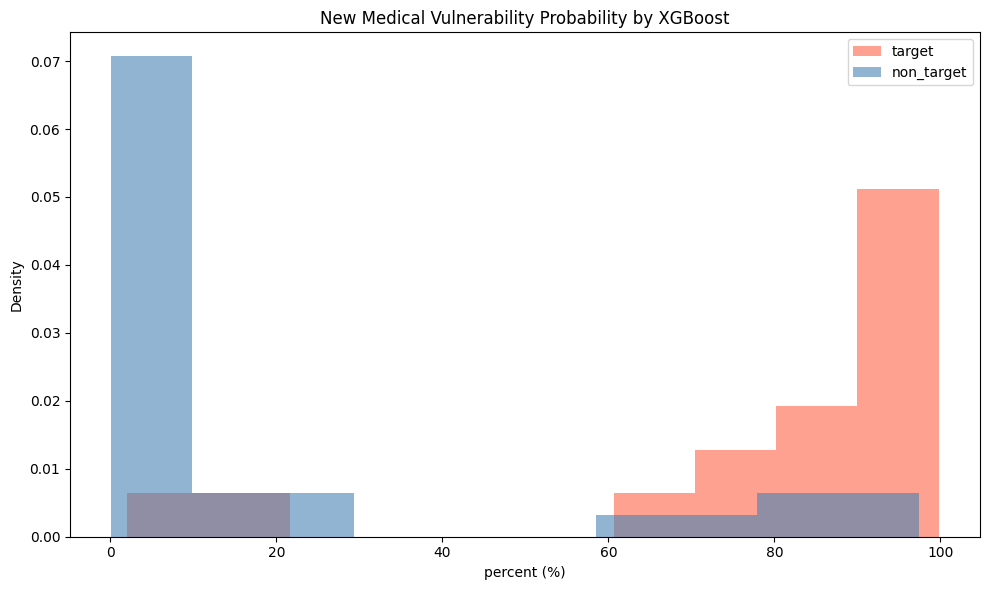

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 타깃
cluster_d = [
    "대구광역시", "광주광역시", "대전광역시", "세종특별자치시",
    "경기도 의정부", "경기도 광명", "경기도 동두천", "경기도 과천", "경기도 구리",
    "경기도 남양주", "경기도 오산", "경기도 시흥", "경기도 군포", "경기도 의왕",
    "경기도 하남", "경기도 파주", "경기도 이천", "경기도 안성", "경기도 김포",
    "경기도 화성", "경기도 광주", "경기도 양주", "경기도 포천", "경기도 여주",
    "경기도 연천", "경기도 양평", "충청북도 충주", "충청북도 제천", "충청북도 증평",
    "충청북도 진천", "충청북도 음성", "충청남도 아산", "충청남도 서산", "충청남도 당진",
    "충청남도 홍성", "전라남도 목포", "전라남도 광양", "전라남도 영암",
    "경상북도 김천", "경상북도 영주", "경상북도 경산", "경상북도 칠곡",
    "경상남도 진주", "경상남도 김해", "경상남도 거제", "경상남도 양산",
    "경기도 수원", "경기도 성남", "경기도 고양", "경기도 용인", "경기도 안양",
    "충청남도 천안"
]

# df는 이미 pm_score, hazard_score, area_score, pop_score 컬럼이 존재한다고 가정
df['cluster_D'] = df['지역'].apply(lambda x: 1 if x in cluster_d else 0)

features = ['pm_score', 'hazard_score', 'area_score', 'pop_score']
df[features] = df[features].fillna(df[features].mean())

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df['cluster_D'],
    test_size=0.3,
    stratify=df['cluster_D'],
    random_state=42
)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE 오버샘플링 (학습 데이터만)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

# XGBoost 모델 학습
model_xgb = XGBClassifier(
    scale_pos_weight=len(y_res[y_res==0])/len(y_res[y_res==1]),
    random_state=42
)
model_xgb.fit(X_res, y_res)

# 테스트 데이터 예측확률 계산 (의료취약확률)
y_proba_test = model_xgb.predict_proba(X_test_scaled)[:, 1]
df_test = X_test.copy()
df_test['cluster_D'] = y_test.values
df_test['의료취약확률'] = y_proba_test * 100  # 0~100 점수화

# 평가 및 리포트
y_pred_test = (y_proba_test >= 0.5).astype(int)
print("\n✅ XGBoost Test Set 분류 리포트:")
print(classification_report(y_test, y_pred_test))
print(f"Test Set ROC AUC: {roc_auc_score(y_test, y_proba_test):.4f}")

plt.figure(figsize=(10,6))

# 타깃군집과 비타깃군집의 확률 분포 히스토그램
plt.hist(
    df_test[df_test['cluster_D'] == 1]['의료취약확률'],
    bins=10, alpha=0.6, color='tomato', label='target', density=True
)
plt.hist(
    df_test[df_test['cluster_D'] == 0]['의료취약확률'],
    bins=10, alpha=0.6, color='steelblue', label='non_target', density=True
)

plt.title('New Medical Vulnerability Probability by XGBoost')
plt.xlabel('percent (%)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

